## Machine Learning for Medicine TP1
### Decision Trees and Random Forest
#### Name : Oussama Azizi

In [50]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_score
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import graphviz
import matplotlib

In [13]:
data_diabetes = pd.read_table("./data/patients_data.txt",
                              sep="\t",
                              header=None,
                              names = ["age", "HbA rate", "insuline", "other drugs"])

classes_diabetes = pd.read_table("./data/patients_classes.txt",
                                 sep="\t",
                                 header=None,
                                 names = ["Diabetes non-remission"])

In [39]:
data_diabetes.head()

,age,HbA rate,insuline,other drugs
0,51.650893,9.679493,0,0
1,64.627752,7.970522,0,1
2,69.550752,6.368363,1,0
3,65.270695,8.812844,0,1
4,62.681176,10.322206,1,1


In [40]:
classes_diabetes.head()

,Diabetes non-remission
0,1
1,1
2,1
3,1
4,1


### 1. Decision Trees model

In [4]:
DT_model = DecisionTreeClassifier()
DT_model = DT_model.fit(data_diabetes, classes_diabetes)

In [5]:
feature_names = ["age", "hba1c", "insuline taken", "other drugs taken"]
classes = ["DR", "NDR"]

dot_data = export_graphviz(DT_model, out_file=None,
                                feature_names=feature_names,
                                class_names=classes,
                                filled=True,
                                rounded=True,
                                special_characters=True)

graph = graphviz.Source(dot_data)
graph.render("diabetes remission")

'diabetes remission.pdf'

### 2. Random Forest model

In [6]:
RF_model = RandomForestClassifier(max_depth=2, random_state=0)
RF_model.fit(data_diabetes, classes_diabetes)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/oussama/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=2, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [7]:
RF_model.predict(data_diabetes)
RF_model.feature_importances_

array([0.57112592, 0.14837838, 0.18705705, 0.09343866])

### 3. The DiaRem Score

In [14]:
## preprocessing
data_diabetes_ = data_diabetes.copy()
data_diabetes_['age'] = round(data_diabetes['age'])
data_diabetes_['HbA rate'] = round(data_diabetes['HbA rate'] / 100, 3)

In [46]:
data_diabetes_.head()

,age,HbA rate,insuline,other drugs
0,52.0,0.097,0,0
1,65.0,0.080,0,1
2,70.0,0.064,1,0
3,65.0,0.088,0,1
4,63.0,0.103,1,1


In [15]:
def age_score(age):
    return (age < 40) * 0 + ((age >= 40) & (age < 49)) * 1 + ((age >= 49) & (age < 59)) * 2 + (age >= 60) * 3

def HbA_score(HbA_rate):
    return (HbA_rate < 0.065) * 0 + ((HbA_rate >= 0.065) & (HbA_rate < 0.069)) * 2 + ((HbA_rate >= 0.07) & (HbA_rate < 0.089)) * 4 + (HbA_rate >= 0.09) * 6

def insuline_score(insuline):
    return (insuline == 1) * 10

def drugs_score(drugs):
    return (drugs == 1) * 3

def DiaRem_score(patient):
    return age_score(patient['age']) + HbA_score(patient['HbA rate']) + insuline_score(patient['insuline']) + drugs_score(patient['other drugs'])

data_diabetes_['DiaRem_score'] = data_diabetes_.apply(DiaRem_score, axis=1)

### 4. Models comparaison

In [16]:
y_true = classes_diabetes['Diabetes non-remission'].values
DiaRem_predict = (data_diabetes_['DiaRem_score'] >= 7).astype(int).values
DT_predict = DT_model.predict(data_diabetes)
RF_predict = RF_model.predict(data_diabetes)

In [54]:
precision_score(y_true, RF_predict).round(2)

0.78

In [63]:
print("Random Forest precision : {} %".format(precision_score(y_true, RF_predict).round(4) *100))
print("Decision Trees precision : {} %".format(precision_score(y_true, DT_predict).round(4) *100))
print("DiaRem Score : {} %".format(precision_score(y_true, DiaRem_predict).round(3) *100))

Random Forest precision : 77.89 %
Decision Trees precision : 100.0 %
DiaRem Score : 67.2 %


The Decision Trees clearly overfits while the Random Forest has a better precision than the DiaRem score

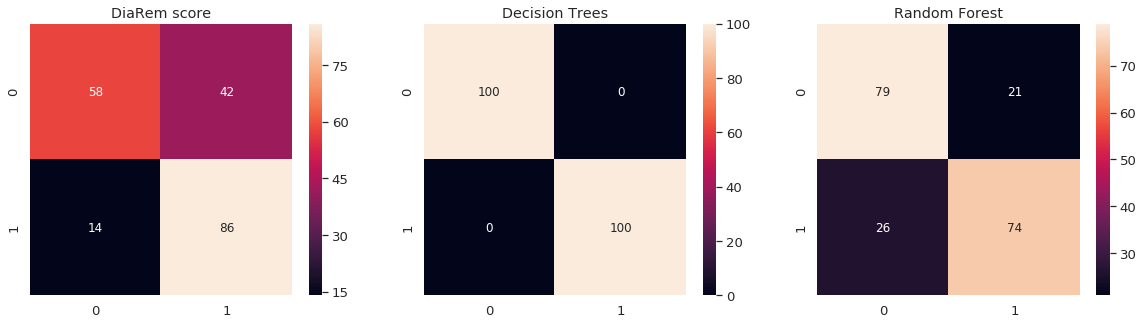

In [46]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize = (20,5))
predicts = [DiaRem_predict, DT_predict, RF_predict]
titles = ['DiaRem score', 'Decision Trees', 'Random Forest']

for i, row in enumerate(ax):
    row.set_title(titles[i])
    row.set_xlabel("true label")
    row.set_ylabel("prediction")
    sn.set(font_scale=1.2) # for label size
    sn.heatmap(confusion_matrix(y_true, predicts[i]),
       ax = row,
       annot=True,
       fmt='g',
       annot_kws={"size":12}) # font size
plt.show()

We conclude that the Decision Trees model overfits, while the DiaRem performs worse than the Random Forest model when it comes to false positives but better when it comes to false negatives.